In [142]:
import pandas as pd
import numpy as np
import datetime as dt

from tensorflow import keras
import tensorflow as tf
from keras.utils import timeseries_dataset_from_array
from keras import layers, regularizers
from keras_tuner import HyperModel
from keras_tuner.tuners import BayesianOptimization

import plotly.express as px
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

## Importación de datos

Leemos el archivo y ordenamos por datetime

In [168]:
data_df = pd.read_csv('data_training/predictores_modelo_pasado.csv')
data_df['Datetime_hour'] = pd.to_datetime(data_df['Datetime_hour'])
data_df = data_df.sort_values(by=['Datetime_hour']).reset_index(drop=True)
data_df

,Datetime_hour,Gen.PBF Hidraulica,Gen.PBF Nuclear,Gen.PBF Fotovoltaica,Gen.PVP Ciclo Combinado,Pot.Indisponible PBF,MD,IDA1,IDA2,Gen.PBF Eolica,Demanda PBF,Interconexiones PBF,Gen.PBF Total,Hour,Month,Day_of_week,Precio_Gas,Precio_CO2_lag24
0,2023-01-03 00:00:00,4959.6,7078.7,5.1,3091.6,5742.6,130.01,118.40,116.01,3357.4,21934.7,1181.1,21155.4,1.0,1.0,1.0,65.98,83.18
1,2023-01-03 01:00:00,4109.4,7078.7,5.1,2888.6,5742.6,120.00,115.00,114.90,3379.1,20466.0,1172.6,19802.2,2.0,1.0,1.0,65.98,83.18
2,2023-01-03 02:00:00,4086.7,7078.7,5.1,2889.3,5742.6,118.76,115.00,114.90,3377.8,19508.1,419.4,19650.6,3.0,1.0,1.0,65.98,83.18
3,2023-01-03 03:00:00,4079.2,7078.7,5.1,2869.8,5742.6,115.00,114.90,112.01,3384.1,19021.5,155.8,19427.6,4.0,1.0,1.0,65.98,83.18
4,2023-01-03 04:00:00,4078.0,7078.7,5.1,2876.1,5742.6,113.63,113.73,108.55,3407.4,19116.1,266.4,19461.6,5.0,1.0,1.0,65.98,83.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23203,2025-08-26 19:00:00,3126.0,6797.4,7928.1,2434.6,12197.2,103.14,129.80,132.77,7140.8,29614.7,-2335.0,32255.7,21.0,8.0,1.0,33.00,71.48
23204,2025-08-26 20:00:00,5212.2,6797.7,2051.6,2487.5,12197.1,117.00,127.76,136.32,7428.8,29657.2,907.9,29055.3,22.0,8.0,1.0,33.00,71.48
23205,2025-08-26 21:00:00,5335.9,6798.7,38.2,3128.5,12197.0,123.46,122.46,130.87,7772.0,30167.2,3155.1,27318.1,23.0,8.0,1.0,33.00,71.48
23206,2025-08-26 22:00:00,4944.7,6802.4,1.3,3045.1,12196.9,113.12,114.12,119.91,7737.2,28282.3,2154.8,26433.5,0.0,8.0,2.0,33.02,72.18


### Visualización inicial

Visualizamos la forma de la función target para las últimas 2 semanas

In [94]:
px.line(data_df.iloc[-2*24*7:], x='Datetime_hour', y='MD', labels={'MD':'Precio MD (€)', 'Datetime_hour':'Tiempo'})

In [95]:
px.line(data_df.iloc[-2*24:], x='Datetime_hour', y='MD', labels={'MD':'Precio MD (€)', 'Datetime_hour':'Tiempo'})

## Analisis de correlacion

In [96]:
data_df['MD_H+24'] = data_df['MD'].shift(-24)
data_df[['Datetime_hour', 'MD', 'MD_H+24']]

,Datetime_hour,MD,MD_H+24
0,2023-01-03 00:00:00,130.01,119.99
1,2023-01-03 01:00:00,120.00,100.00
2,2023-01-03 02:00:00,118.76,90.23
3,2023-01-03 03:00:00,115.00,84.20
4,2023-01-03 04:00:00,113.63,80.23
...,...,...,...
23203,2025-08-26 19:00:00,103.14,NaN
23204,2025-08-26 20:00:00,117.00,NaN
23205,2025-08-26 21:00:00,123.46,NaN
23206,2025-08-26 22:00:00,113.12,NaN


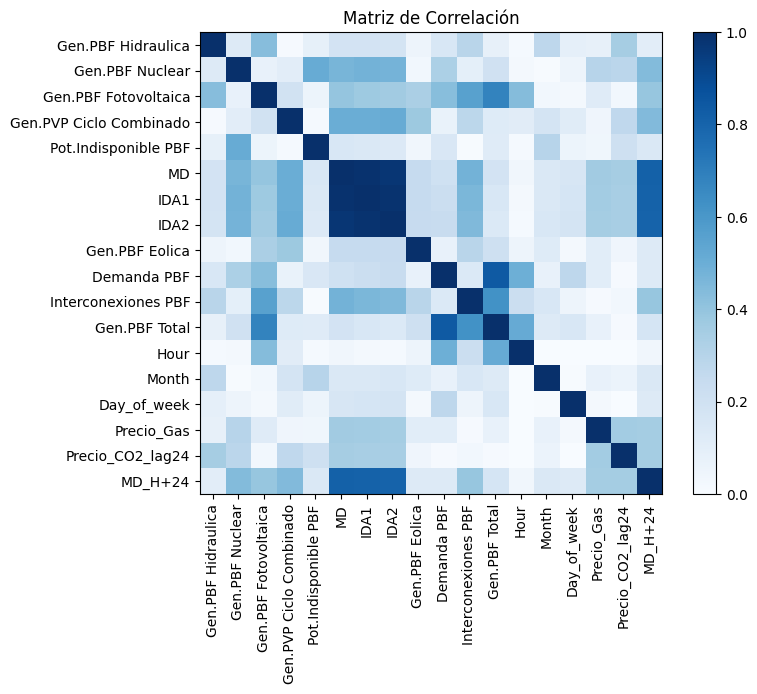

In [97]:
df_sin_fecha = data_df.drop(columns=['Datetime_hour'])

correlation_matrix = df_sin_fecha.corr()
correlation_matrix = correlation_matrix.abs()

plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap='Blues', interpolation='none', vmin=0, vmax=1)
plt.colorbar()
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)
plt.title('Matriz de Correlación')
plt.show()

data_df.drop(columns=['MD_H+24'], inplace=True)

## Parte 1 - Modelo con 24 outputs

### Preparacion datos

In [188]:
def create_sequences(df, input_steps, output_steps, target_column):
    X, y = [], []
    data = df.values
    target_idx = df.columns.get_loc(target_column)

    for i in range(0, len(df) - input_steps - output_steps + 1, output_steps):
        X.append(data[i:i+input_steps, :])  # Ventana de entrada
        y.append(data[i+input_steps:i+input_steps+output_steps, target_idx])  # Ventana de salida

    return np.array(X), np.array(y)

In [212]:
### PARAMETROS
fecha_inicio = '2025-01-01'
cols_to_drop = ['IDA1', 'IDA2', 'Gen.PBF Hidraulica', 'Pot.Indisponible PBF', 'Hour', 'Month']

input_days = 7
val_days = 30 + input_days
test_days = 14 + input_days
features = [col for col in data_df.columns if col not in ['Datetime_hour']]

input_steps = 24*input_days
output_steps = 24

batch_size = 16

In [213]:
# Seleccionar valores
# data_df = data_df.loc[(data_df['Datetime_hour'] >= fecha_inicio) & (data_df['Datetime_hour'] <= fecha_fin)]
data_df_clean = data_df.drop(columns=cols_to_drop)


# Número de muestras
num_test_samples = test_days * 24
num_val_samples = val_days * 24
num_train_samples = len(data_df_clean) - num_val_samples - num_test_samples
# Division en train, val y test
data_df_input = data_df_clean.drop(columns=['Datetime_hour'])
train_df = data_df_input.iloc[:num_train_samples].copy()
val_df = data_df_input.iloc[num_train_samples:num_train_samples + num_val_samples].copy()
test_df = data_df_input.iloc[num_train_samples + num_val_samples:].copy()



# Escalado de features (X)
predictors = [col for col in train_df.columns if col not in ['MD', 'Datetime_hour']]
x_scaler = StandardScaler()

train_df.loc[:, predictors] = x_scaler.fit_transform(train_df[predictors])
val_df.loc[:, predictors]   = x_scaler.transform(val_df[predictors])
test_df.loc[:, predictors]  = x_scaler.transform(test_df[predictors])


# Escalado de target (y)
y_scaler = StandardScaler()

train_df.loc[:, 'MD'] = y_scaler.fit_transform(train_df[['MD']])
val_df.loc[:, 'MD']   = y_scaler.transform(val_df[['MD']])
test_df.loc[:, 'MD']  = y_scaler.transform(test_df[['MD']])


# Ventanas temporales
X_train, y_train = create_sequences(train_df, input_steps, output_steps, 'MD')
X_val, y_val = create_sequences(val_df, input_steps, output_steps, 'MD')
X_test, y_test = create_sequences(test_df, input_steps, output_steps, 'MD')

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Train: {y_train.shape}, Val: {y_val.shape}, Test: {y_test.shape}")

Train: (902, 168, 11), Val: (30, 168, 11), Test: (14, 168, 11)
Train: (902, 24), Val: (30, 24), Test: (14, 24)


## Modelo LSTM

In [133]:
### PARAMETROS
dropout = 0.3
n_neurons = 64
n_capas = 3
r_drop = 0.1
patience = 15
lr = 0.001
n_epochs = 50
regularizer = keras.regularizers.l2(1e-4)

In [134]:
n_features = X_train.shape[-1]

# Entrada
inputs = keras.Input(shape=(input_steps, n_features))
# Primera capa
x = keras.layers.LSTM(n_neurons, recurrent_dropout=r_drop, activation='tanh', return_sequences=True, kernel_regularizer=regularizer)(inputs)
x = keras.layers.Dropout(dropout)(x)
x = keras.layers.LayerNormalization()(x)
# Resto de capas
for _ in range(n_capas-1):
    rs = False if _ == n_capas-2 else True
    x = keras.layers.LSTM(n_neurons, recurrent_dropout=r_drop, activation='tanh', return_sequences=rs, kernel_regularizer=regularizer)(x)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.LayerNormalization()(x)
# Salida
outputs = keras.layers.Dense(24)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("lstm_multioutput.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
]

optimizer = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
history = model.fit(X_train, y_train,
                    epochs=n_epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
29/29 [==============================] - 7s 96ms/step - loss: 1.2982 - mae: 0.8911 - val_loss: 0.5849 - val_mae: 0.5816
Epoch 2/50
29/29 [==============================] - 2s 80ms/step - loss: 0.8024 - mae: 0.6965 - val_loss: 0.4723 - val_mae: 0.5362
Epoch 3/50
29/29 [==============================] - 2s 83ms/step - loss: 0.6837 - mae: 0.6413 - val_loss: 0.4180 - val_mae: 0.5049
Epoch 4/50
29/29 [==============================] - 2s 85ms/step - loss: 0.5867 - mae: 0.5871 - val_loss: 0.3942 - val_mae: 0.4917
Epoch 5/50
29/29 [==============================] - 2s 81ms/step - loss: 0.5239 - mae: 0.5551 - val_loss: 0.3572 - val_mae: 0.4597
Epoch 6/50
29/29 [==============================] - 2s 82ms/step - loss: 0.4792 - mae: 0.5270 - val_loss: 0.3191 - val_mae: 0.4313
Epoch 7/50
29/29 [==============================] - 2s 86ms/step - loss: 0.4272 - mae: 0.4962 - val_loss: 0.2833 - val_mae: 0.4003
Epoch 8/50
29/29 [==============================] - 2s 80ms/step - loss: 0.4076 - m

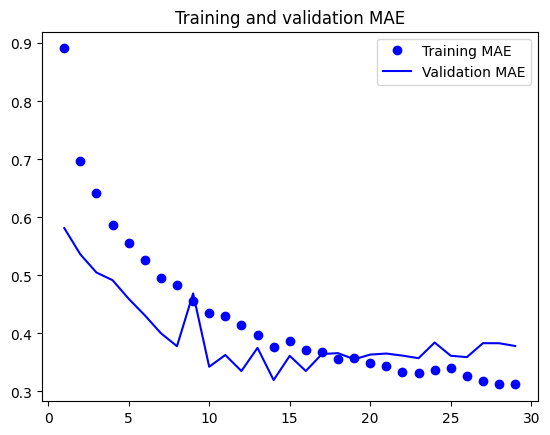

In [135]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Evaluación y resultados

In [137]:
model = keras.models.load_model("lstm_multioutput.keras")
y_pred = model.predict(X_test)

y_pred_rescaled = y_scaler.inverse_transform(y_pred)
y_test_rescaled = y_scaler.inverse_transform(y_test)


rmse = np.sqrt(mean_squared_error(y_test_rescaled.flatten(), y_pred_rescaled.flatten()))
mae  = mean_absolute_error(y_test_rescaled.flatten(), y_pred_rescaled.flatten())

# print(f"RMSE: {rmse:.3f}")
print(f"MAE : {mae:.3f}")

1/1 [==============================] - 0s 423ms/step
MAE : 15.013


In [138]:
test_dates = data_df['Datetime_hour'].iloc[-num_test_samples:].reset_index(drop=True)

# Como y_test tiene forma (n_muestras, 24), lo aplanamos
y_test_flat = y_test_rescaled.flatten()
y_pred_flat = y_pred_rescaled.flatten()

# Cortamos las fechas para que coincidan con el tamaño
test_dates = test_dates.iloc[:len(y_test_flat)]

# --- Crear dataframe para graficar ---
df_plot = pd.DataFrame({
    "Datetime": test_dates,
    "Real": y_test_flat,
    "Predicción": y_pred_flat
})

# Pasamos a formato long (para usar plotly express más fácil)
df_melted = df_plot.melt(id_vars="Datetime", value_vars=["Real", "Predicción"],
                         var_name="Serie", value_name="Precio")

fig = px.line(df_melted,x="Datetime",y="Precio",color="Serie",title="Predicciones vs Valores Reales (Test Set)",
    labels={"Precio": "Precio (Escala Original)", "Serie": "Leyenda"},
    color_discrete_map={"Real": "blue", "Predicción": "orange"}
)

# Personalizar el gráfico
fig.update_layout(
    title_font_size=16,
    xaxis_title="Fecha",
    xaxis_title_font_size=14,
    yaxis_title="Precio (Escala Original)",
    yaxis_title_font_size=14,
    legend_title="",
    width=1000,
    height=500,
    template="plotly_white",
    hovermode="x unified"
)

# Ajustar la opacidad de la línea de predicción
fig.update_traces(opacity=0.7, selector={"legendgroup": "Predicción"})

# Mostrar la cuadrícula
fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)

fig.show()

## Calculo del error base

Tenemos que establecer un objetivo de precisión para nuestro modelo. Para ello, suponemos dos pronósticos iniciales:
1. El precio a la misma hora del día anterior
2. El precio a la misma hora y el mismo día de la semana anterior

Consideramos esta segunda posibilidad, debido a la gran diferencia que existe entre los precios en fin de semana y entre semana.

In [125]:
md_true = []
md_delay_day = []
data_array = data_df_input.values

# Calculamos los targets para el dataset sin escalar
for i in range(len(data_array) - input_steps - output_steps):
    md_true.append(data_array[i+input_steps:i+input_steps+output_steps, features.index('MD')])
    # Delay de 1 dia
    md_delay_day.append(data_array[i+input_steps-24:i+input_steps+output_steps-24, features.index('MD')])


md_true = np.array(md_true)
md_delay_day = np.array(md_delay_day)

print(f"MAE day-delay: {np.mean(np.abs(md_true - md_delay_day))}")

MAE day-delay: 19.21110949380838


Evolución del entrenamiento

In [99]:
y_pred_rescaled.shape

(923, 24)

## Tuning de hiperparametros

In [214]:
class HyperModel_LSTM(HyperModel):
    def __init__(self, input_steps, n_features):
        self.input_steps = input_steps
        self.n_features = n_features

    def build(self, hp):
        # Hiperparámetros a tunear
        n_capas = hp.Int('n_capas', min_value=2, max_value=3)  # número de capas LSTM
        n_neurons = hp.Choice('n_neurons', values=[32,64])   # neuronas por capa
        lr = hp.Choice('lr', values=[1e-3, 5e-4])              # learning rate
        dropout = hp.Float('dropout', min_value=0.1, max_value=0.3, step=0.1)
        r_drop = hp.Choice('r_drop', values=[0.1, 0.2])  # recurrent_dropout opcional
        regularizer = regularizers.l2(1e-4)

        # Entrada
        inputs = keras.Input(shape=(self.input_steps, self.n_features))

        # Primera capa
        x = layers.LSTM(n_neurons, recurrent_dropout=r_drop, activation='tanh', return_sequences=True, kernel_regularizer=regularizer)(inputs)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization()(x)

        # Resto de capas
        for i in range(n_capas - 1):
            rs = True if i < n_capas - 2 else False
            x = layers.LSTM(n_neurons, recurrent_dropout=r_drop, activation='tanh', return_sequences=rs, kernel_regularizer=regularizer)(x)
            x = layers.Dropout(dropout)(x)
            x = layers.LayerNormalization()(x)

        # Salida (24 pasos a predecir)
        outputs = layers.Dense(24)(x)

        model = keras.Model(inputs, outputs)

        # Compilación
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=lr),
            loss='mse',
            metrics=['mae']
        )

        return model

In [215]:
# Inicializar HyperModel
hypermodel_lstm = HyperModel_LSTM(input_steps=X_train.shape[1], 
                                  n_features=X_train.shape[2])

# Definir tuner
tuner = BayesianOptimization(
    hypermodel_lstm,
    objective='val_mae',
    max_trials=15,
    executions_per_trial=2,
    directory='kt_dir',
    project_name='hp_modelo_lstm_7d_2025'
)

# Callback EarlyStopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Búsqueda de hiperparámetros
tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop]
)


Trial 15 Complete [00h 04m 47s]
val_mae: 0.3001680076122284

Best val_mae So Far: 0.3001680076122284
Total elapsed time: 02h 02m 02s


In [216]:
# Mejor modelo y mejores hiperparámetros
best_model = tuner.get_best_models(1)[0]
best_hp = tuner.get_best_hyperparameters(1)[0]

print("Mejores hiperparámetros:", best_hp.values)

Mejores hiperparámetros: {'n_capas': 2, 'n_neurons': 64, 'lr': 0.001, 'dropout': 0.1, 'r_drop': 0.2}


In [217]:
y_pred = best_model.predict(X_test)

y_pred_rescaled = y_scaler.inverse_transform(y_pred)
y_test_rescaled = y_scaler.inverse_transform(y_test)


rmse = np.sqrt(mean_squared_error(y_test_rescaled.flatten(), y_pred_rescaled.flatten()))
mae  = mean_absolute_error(y_test_rescaled.flatten(), y_pred_rescaled.flatten())

# print(f"RMSE: {rmse:.3f}")
print(f"MAE : {mae:.3f}")

1/1 [==============================] - 0s 341ms/step
MAE : 12.504


In [218]:
test_dates = data_df['Datetime_hour'].iloc[-num_test_samples:].reset_index(drop=True)

# Como y_test tiene forma (n_muestras, 24), lo aplanamos
y_test_flat = y_test_rescaled.flatten()
y_pred_flat = y_pred_rescaled.flatten()

# Cortamos las fechas para que coincidan con el tamaño
test_dates = test_dates.iloc[:len(y_test_flat)]

# --- Crear dataframe para graficar ---
df_plot = pd.DataFrame({
    "Datetime": test_dates,
    "Real": y_test_flat,
    "Predicción": y_pred_flat
})

# Pasamos a formato long (para usar plotly express más fácil)
df_melted = df_plot.melt(id_vars="Datetime", value_vars=["Real", "Predicción"],
                         var_name="Serie", value_name="Precio")

fig = px.line(df_melted,x="Datetime",y="Precio",color="Serie",title="Predicciones vs Valores Reales (Test Set)",
    labels={"Precio": "Precio (Escala Original)", "Serie": "Leyenda"},
    color_discrete_map={"Real": "blue", "Predicción": "orange"}
)

# Personalizar el gráfico
fig.update_layout(
    title_font_size=16,
    xaxis_title="Fecha",
    xaxis_title_font_size=14,
    yaxis_title="Precio (Escala Original)",
    yaxis_title_font_size=14,
    legend_title="",
    width=1000,
    height=500,
    template="plotly_white",
    hovermode="x unified"
)

# Ajustar la opacidad de la línea de predicción
fig.update_traces(opacity=0.7, selector={"legendgroup": "Predicción"})

# Mostrar la cuadrícula
fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)

fig.show()